In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_excel('data.xlsx')

In [3]:
data.head(2)

,company_name,url,category
0,Advent International Corp.,www.adventinternational.com,VC
1,Crescent Real Estate Holdings LLC,www.crescent.com,VC


In [4]:
from sklearn.utils import shuffle
data = shuffle(data,random_state=0)

In [5]:
data.head(2)

,company_name,url,category
18,The Argentum Group (New York),www.argentumgroup.com,VC
169,"IT Group, Inc.",www.theitgroup.com,Non VC


In [6]:
new = data['url'].str.split(".",n=2,expand = True)
data['url_name'] = new[1]

In [7]:
data.head(2)

,company_name,url,category,url_name
18,The Argentum Group (New York),www.argentumgroup.com,VC,argentumgroup
169,"IT Group, Inc.",www.theitgroup.com,Non VC,theitgroup


In [8]:
data = data.drop(['url','url_name'],axis=1)

In [9]:
data.head()

,company_name,category
18,The Argentum Group (New York),VC
169,"IT Group, Inc.",Non VC
106,"Alpine Group, Inc.",Non VC
92,Pacific Private Capital LLC,VC
176,"Kettle Restaurants, Inc.",Non VC


In [10]:
data['category_id'] = data['category'].factorize()[0]
from io import StringIO
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [11]:
data.head()

,company_name,category,category_id
18,The Argentum Group (New York),VC,0
169,"IT Group, Inc.",Non VC,1
106,"Alpine Group, Inc.",Non VC,1
92,Pacific Private Capital LLC,VC,0
176,"Kettle Restaurants, Inc.",Non VC,1


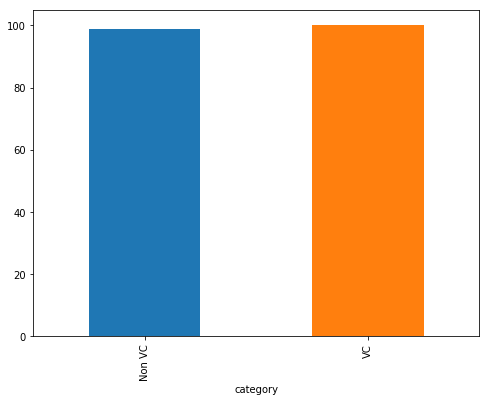

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('category').company_name.count().plot.bar(ylim=0)
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 4), stop_words='english')

features = tfidf.fit_transform(data.company_name).toarray()
labels = data.category_id
features.shape

(199, 16)

In [14]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Non VC':
  . Most correlated unigrams:
       . capital
       . partners
  . Most correlated bigrams:
       . management llc
       . partners llc
# 'VC':
  . Most correlated unigrams:
       . capital
       . partners
  . Most correlated bigrams:
       . management llc
       . partners llc


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

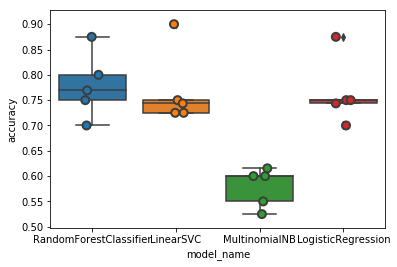

In [16]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.768718
LogisticRegression        0.763718
MultinomialNB             0.578077
RandomForestClassifier    0.778846
Name: accuracy, dtype: float64

In [18]:
from sklearn import svm
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 2,3,4,5]
    gammas = [0.00001,0.0001,0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [19]:
svc_param_selection(X_train, y_train, 2)

{'C': 2, 'gamma': 0.1}

In [20]:
from sklearn.svm import SVC
model = SVC(C=1,gamma=1, kernel='rbf')
model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [21]:
rfc_train_pred = model.predict(X_train)
rfc_test_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score 
print("Train")
print(accuracy_score(y_train,rfc_train_pred))

print("Test")
print(accuracy_score(y_test,rfc_test_pred))

Train
0.8045112781954887
Test
0.7878787878787878


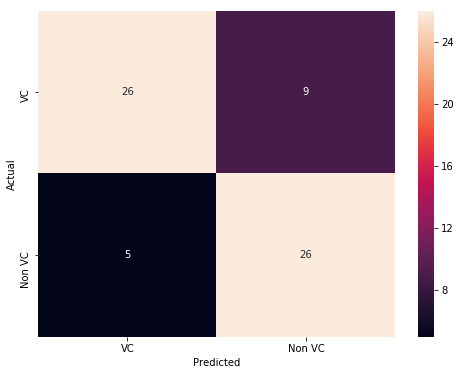

In [22]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, rfc_test_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(data['company_name'], data['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

clf = MultinomialNB(alpha=1).fit(X_train_tfidf, y_train)

In [24]:
y_train_pred = clf.predict(X_train_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score 
print("Train")
print(accuracy_score(y_train,y_train_pred))

print("Test")
print(accuracy_score(y_test,y_test_pred))

Train
0.9530201342281879
Test
0.82


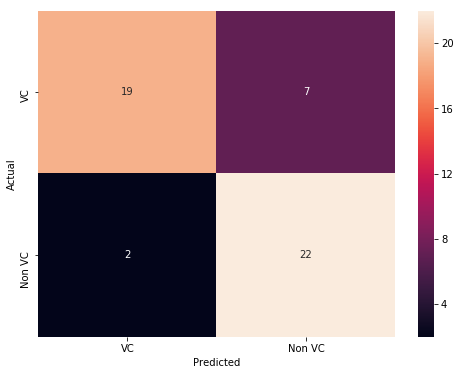

In [25]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
print(clf.predict(count_vect.transform(["Auto-trol Technology Corp."])))

['Non VC']
